# 2nd go: using Gaussian + GP to model CCF

Suzanne Aigrain @ Oxford, May 2019

In [91]:
%pylab inline
import pickle

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['ndim', 'std', 'axes', 'var']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Read in CCFs from 2018 and select very quiet period when the Jupiter RV signal is approx constant to construct CCF reference.

In [92]:
year = '2018'
with open('ccf_'+year,'rb') as infile:
    ccfYear = pickle.load(infile)
nobs,nvel = np.shape(ccfYear)
crval1 = -20
cdelt1 = 0.25
vel = np.arange(nvel)*cdelt1 + crval1

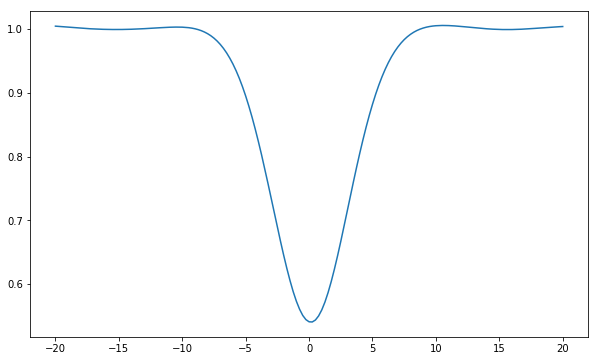

In [93]:
ccfRef = np.mean(ccfYear[125:150,:],axis=0)
#ccfRef = ccfYear[130,:].flatten()
plt.figure(figsize=(10,6))
plt.plot(vel,ccfRef,'C0-')


First model the CCF using a Gaussian and examine residuals

[0.45 0.   3.5 ]
[0.46033825 0.11569878 2.94921493]


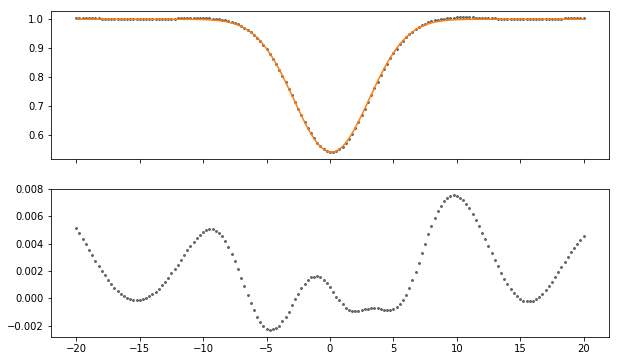

In [94]:
def CCFGauss(p,x):
    return 1.0 - p[0] * exp(-(x-p[1])**2/2.0/p[2]**2)
def nllG(p,x,y):
    r = y - CCFGauss(p,x)
    return (r**2).sum()
p0 = np.array([0.45,0.0,3.5])
print(p0)
from scipy.optimize import minimize
soln = minimize(nllG,p0,args=(vel,ccfRef))
p1 = soln.x
print(p1)
g = CCFGauss(p1,vel)
r = ccfRef - g
fig,axes = plt.subplots(2,1,figsize=(10,6),sharex = True)
axes[0].plot(vel,ccfRef, 'k.', ms = 4, alpha = 0.5)
axes[0].plot(vel,g,'C1')
axes[1].plot(vel,r, 'k.', ms = 4, alpha = 0.5)

Now model the residuals with a GP. Visual inspection suggests a rational quadratic would work well and indeed it does a better job than a squared exponential.

[ 0.          2.30258509  0.         -0.10536052]
[ 1.92823596e-05  2.30258029e+00 -5.85229945e-06 -1.05364107e-01]


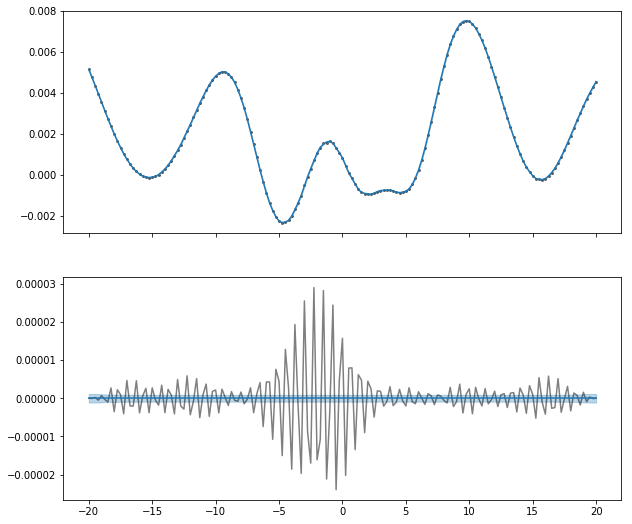

In [95]:
from george import kernels, GP
#k = 1.0 * kernels.RationalQuadraticKernel(-0.3,1.0) 
k1 = 1.0 * kernels.ExpSquaredKernel(10.0)
k2 = 1.0 * kernels.ExpSquaredKernel(0.9) 
gp = GP(k1+k2)
def nllGP(p,x,y):
    gp.set_parameter_vector(p)
    gp.compute(x)
    return -gp.lnlikelihood(y, quiet=True)
p2 = gp.get_parameter_vector()
print(p2)
soln = minimize(nllGP,p2,args=(vel,r))
p3 = soln.x
print(p3)
gp.set_parameter_vector(p3)
mu, var = gp.predict(r, vel, return_var=True)
std = np.sqrt(var)
fig,axes = plt.subplots(2,1,figsize=(10,9),sharex = True)
axes[0].plot(vel,r, 'k.', ms = 4, alpha = 0.5)
axes[0].plot(vel,mu)
axes[0].fill_between(vel,mu+std,mu-std,alpha=0.3,color='C0')
axes[1].plot(vel,r-mu, 'k-', ms = 4, alpha = 0.5)
axes[1].plot(vel,mu-mu)
axes[1].fill_between(vel,std,-std,alpha=0.3,color='C0')

Kind of eerie! Let's fit the Gaussian and the GP jointly to be safe.

[ 4.60338251e-01  1.15698783e-01  2.94921493e+00  1.92823596e-05
  2.30258029e+00 -5.85229945e-06 -1.05364107e-01]
[ 4.60338251e-01  1.15698783e-01  2.94921493e+00  1.92823596e-05
  2.30258029e+00 -5.85229945e-06 -1.05364107e-01]


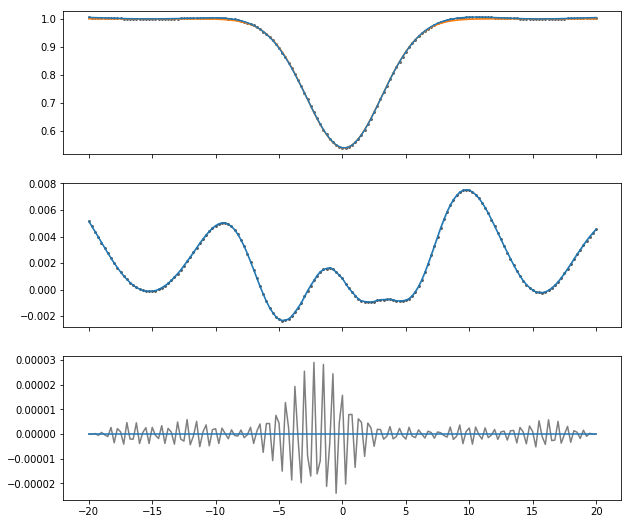

In [96]:
def nllGGP(p,x,y,yerr =1e-6):
    gp.set_parameter_vector(p[3:])
    gp.compute(x,yerr=yerr)
    r = y - CCFGauss(p[:3],x)
    return -gp.lnlikelihood(r, quiet=True)
p4 = np.concatenate([p1,p3]).flatten()
print(p4)
soln = minimize(nllGGP,p4,args=(vel,ccfRef,sig))
p5 = soln.x
print(p5)
g = CCFGauss(p5[:3],vel)
r = ccfRef - g
gp.set_parameter_vector(p5[3:])
mu, var = gp.predict(r, vel, return_var=True)
std = np.sqrt(var)
fig,axes = plt.subplots(3,1,figsize=(10,9),sharex = True)
axes[0].plot(vel,ccfRef, 'k.', ms = 4, alpha = 0.5)
axes[0].plot(vel,g,'C1')
axes[0].plot(vel,g+mu,'C0')
axes[1].plot(vel,r, 'k.', ms = 4, alpha = 0.5)
axes[1].plot(vel,mu)
axes[1].fill_between(vel,mu+std,mu-std,alpha=0.3,color='C0')
axes[2].plot(vel,r-mu, 'k-', ms = 4, alpha = 0.5)
axes[2].plot(vel,mu-mu)
#axes[2].fill_between(vel,std,-std,alpha=0.3,color='C0')

Now fit 

[ 4.60338251e-01  1.15698783e-01  2.94921493e+00  1.92823596e-05
  2.30258029e+00 -5.85229945e-06 -1.05364107e-01]
[ 4.60338251e-01  1.15698783e-01  2.94921493e+00  1.92823596e-05
  2.30258029e+00 -1.00000000e+01 -1.05364107e-01]


(-0.003, 0.003)

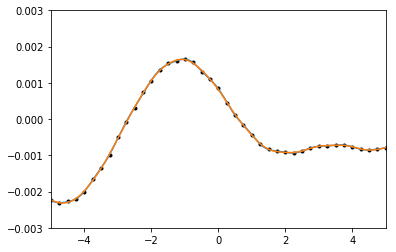

In [97]:
vtight = np.linspace(vel.min(),vel.max(),10*len(vel))
gtight = CCFGauss(p5[:3],vtight)
mutight1 = gp.predict(r, vtight, return_var=False,return_cov=False)
p6 = np.copy(p5)
print(p6)
p6[-2] = -10
print(p6)
gp.set_parameter_vector(p6[3:])
gp.compute(vel)
mutight2 = gp.predict(r, vtight, return_var=False,return_cov=False)
plt.plot(vel,r,'k.')
plt.plot(vtight,mutight1)
plt.plot(vtight,mutight2)
plt.xlim(-5,5)
plt.ylim(-0.003,0.003)